## 使用RNN进行文本分类 - Try LSTM

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 80
pd.options.display.precision = 4
pd.options.display.max_rows = 999
pd.options.display.float_format = '{:.10f}'.format
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [4]:
train_dataset1, test_dataset1 = dataset['train'], dataset['test']

In [5]:
type(train_dataset1)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [6]:
for i, (string_, int_) in enumerate(train_dataset1):
    print(len(string_))
    print(int_)
    if i > 10:
        break

163
tf.Tensor(0, shape=(), dtype=int64)
142
tf.Tensor(0, shape=(), dtype=int64)
200
tf.Tensor(0, shape=(), dtype=int64)
117
tf.Tensor(1, shape=(), dtype=int64)
106
tf.Tensor(1, shape=(), dtype=int64)
421
tf.Tensor(1, shape=(), dtype=int64)
974
tf.Tensor(0, shape=(), dtype=int64)
188
tf.Tensor(0, shape=(), dtype=int64)
313
tf.Tensor(0, shape=(), dtype=int64)
179
tf.Tensor(0, shape=(), dtype=int64)
280
tf.Tensor(0, shape=(), dtype=int64)
394
tf.Tensor(1, shape=(), dtype=int64)


In [7]:
string_.shape

TensorShape([394])

In [8]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [9]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))


Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [10]:
assert original_string == sample_string

In [11]:
for index in encoded_string:
    print('{} ----&gt; {}'.format(index, encoder.decode([index])))

4025 ----&gt; Hell
222 ----&gt; o 
6307 ----&gt; Ten
2327 ----&gt; sor
4043 ----&gt; Fl
2120 ----&gt; ow
7975 ----&gt; .


In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [13]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

### 创建模型

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [15]:
test_layer_embedding = tf.keras.layers.Embedding(encoder.vocab_size, 64)

In [16]:
for x in test_dataset:
    x_out = test_layer_embedding(x[0])
    print(x[0].shape)
    print(x_out.shape)
#     print(x[0])
    break

(64, 933)
(64, 933, 64)


In [17]:
x[0]

<tf.Tensor: shape=(64, 933), dtype=int64, numpy=
array([[ 173,   29,  185, ...,    0,    0,    0],
       [ 133, 2237,   64, ...,    0,    0,    0],
       [3567,   47, 3634, ...,    0,    0,    0],
       ...,
       [4875, 3273,   21, ...,    0,    0,    0],
       [ 644, 7968,   21, ...,    0,    0,    0],
       [3502,  231,   60, ...,    0,    0,    0]])>

In [18]:
len(x[0][0][x[0][0] > 0])

283

In [19]:
np.array(x_out[0, :, :]).argmax(axis=1)

array([62, 41, 10, 23, 21, 55, 18, 60, 38, 44,  8,  5, 16, 36, 53,  6, 33,
       36, 12, 37, 43, 15, 13,  3, 20, 18, 29, 16, 10, 16, 10, 46, 19, 62,
       18, 29, 50, 61, 26, 41, 59, 16, 24, 12, 41, 45,  3, 57, 60,  3, 31,
        0, 23, 18, 46, 34, 42, 52, 50, 53,  5, 63, 57, 50, 55, 21, 56, 21,
       43, 55, 21, 56, 53, 60, 60, 26, 57, 36, 21, 51, 16, 59, 59, 48, 52,
       31, 59, 59, 12, 59, 27, 61, 60, 63, 61, 34, 34, 60, 43, 32, 53, 17,
        1,  2, 63, 16, 43, 26, 37, 16, 36, 12, 36, 35,  8, 15,  1, 16, 62,
       43, 16, 43, 57, 53, 17, 36, 43,  1, 40,  2, 63,  6, 11,  0,  8, 47,
       42, 52, 50, 53,  5, 27, 17, 51, 27, 45, 50, 55, 21, 56, 21, 43, 55,
       21, 56, 53, 31, 17, 54, 19, 43, 16, 61,  5, 16, 60, 25, 31, 23,  6,
       20, 10,  0,  0, 44, 16, 43, 34, 61,  2, 48, 59, 32, 43, 25, 21, 52,
       21, 42, 31, 29, 61, 36,  0, 60, 35,  6, 16, 21, 24, 16,  8,  9, 13,
       59, 25,  2, 13, 61,  3, 60, 61, 50, 17, 47, 16,  2, 47, 43, 56, 27,
       61, 43, 10, 21, 22

In [20]:
testx = np.array(x_out[0, :, :]).argmax(axis=1)
len(testx[testx > 21])

827

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 587s 2s/step - loss: 0.6896 - accuracy: 0.5024 - val_loss: 0.5917 - val_accuracy: 0.6193
Epoch 2/10
391/391 [==============================] - 585s 1s/step - loss: 0.4278 - accuracy: 0.7930 - val_loss: 0.3418 - val_accuracy: 0.8557
Epoch 3/10
391/391 [==============================] - 701s 2s/step - loss: 0.2633 - accuracy: 0.8964 - val_loss: 0.3358 - val_accuracy: 0.8625
Epoch 4/10
391/391 [==============================] - 867s 2s/step - loss: 0.2107 - accuracy: 0.9202 - val_loss: 0.3263 - val_accuracy: 0.8672
Epoch 5/10
391/391 [==============================] - 847s 2s/step - loss: 0.1792 - accuracy: 0.9347 - val_loss: 0.3405 - val_accuracy: 0.8729
Epoch 6/10
391/391 [==============================] - 856s 2s/step - loss: 0.1631 - accuracy: 0.9416 - val_loss: 0.3619 - val_accuracy: 0.8646
Epoch 7/10
391/391 [==============================] - 635s 2s/step - loss: 0.1384 - accuracy: 0.9545 - val_loss: 0.3914 - val_accuracy: 0.8667

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 98s 251ms/step - loss: 0.4398 - accuracy: 0.8517
Test Loss: 0.439797967672348
Test Accuracy: 0.8517199754714966


In [24]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [25]:
def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

In [26]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.35799646]]


In [27]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.39524883]]


<IPython.core.display.Javascript object>


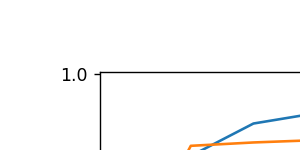

In [28]:
plot_graphs(history, 'accuracy')

In [29]:
plot_graphs(history, 'loss')